# Autocorrelation Function (ACF)

For a (possibly complex-valued) random process $X(t)$, the autocorrelation function is defined as

$$
R_X(t_1, t_2) = \mathbb{E}\left[X(t_1)\,X^*(t_2)\right],
$$

where $\mathbb{E}[\cdot]$ denotes expectation and $(\cdot)^*$ denotes complex conjugation.

If $X(t)$ is wide-sense stationary (WSS), then $R_X$ depends only on the lag $\tau = t_2 - t_1$:

$$
R_X(\tau) = \mathbb{E}\left[X(t)\,X^*(t+\tau)\right].
$$

Discrete-time form (for process $X[n]$):

$$
R_X[k] = \mathbb{E}\left[X[n] \, X^*[n+k]\right].
$$


## Exponential-Decay ACF Model

A common parametric model uses exponential decay:

$$
R_X(\tau) = \sigma_X^2\,e^{-\lvert \tau \rvert/\tau_c},
$$

where $\sigma_X^2 = R_X(0)$ is the process power/variance and $\tau_c$ is the correlation time constant.

For uniformly sampled lags with step $\Delta\tau$, the equivalent discrete forgetting factor is

$$
\lambda = e^{-\Delta\tau/\tau_c},\quad R_X[k] = \sigma_X^2\,\lambda^{\lvert k \rvert}.
$$


Forgetting factor lambda = 0.985816


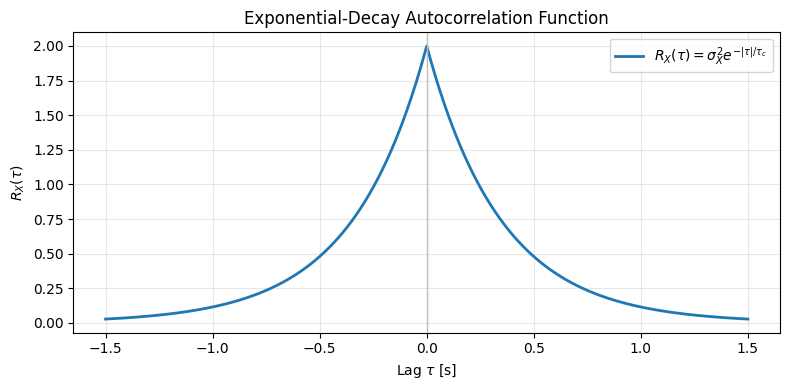

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt


def exponential_acf(
    tau_s: np.ndarray,  # Lag samples [s]
    sigma_x2: float,  # Process variance/power sigma_X^2
    tau_corr_s: float,  # Correlation time constant [s]
) -> np.ndarray:  # Theoretical ACF R_X(tau)
    """Computes an exponentially decaying ACF model.

    Purpose:
        Evaluate the stationary model R_X(tau) = sigma_X^2 * exp(-|tau|/tau_corr_s).

    Parameters:
        tau_s: Lag axis in seconds.
        sigma_x2: Variance/power level (must be non-negative).
        tau_corr_s: Correlation decay constant in seconds (must be positive).

    Returns:
        Array with the same shape as tau_s containing R_X(tau).

    Side effects:
        None.
    """
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")
    if tau_corr_s <= 0.0:
        raise ValueError("tau_corr_s must be strictly positive.")

    # Enforce symmetric exponential decay around tau = 0.
    return sigma_x2 * np.exp(-np.abs(tau_s) / tau_corr_s)


# Configure simulation parameters.
sigma_x2: float = 2.0
tau_corr_s: float = 0.35
tau_max_s: float = 1.5
n_lags: int = 601

# Build lag axis and evaluate the model.
tau_s = np.linspace(-tau_max_s, tau_max_s, n_lags)
r_x_tau = exponential_acf(tau_s=tau_s, sigma_x2=sigma_x2, tau_corr_s=tau_corr_s)

# Map the continuous model to a discrete forgetting factor.
delta_tau_s = float(tau_s[1] - tau_s[0])
lambda_forgetting = float(np.exp(-delta_tau_s / tau_corr_s))
print(f"Forgetting factor lambda = {lambda_forgetting:.6f}")

# Plot the simulated theoretical ACF.
plt.figure(figsize=(8, 4))
plt.plot(tau_s, r_x_tau, lw=2, label=r"$R_X(\tau)=\sigma_X^2 e^{-|\tau|/\tau_c}$")
plt.axvline(0.0, color="0.75", lw=1)
plt.xlabel(r"Lag $\tau$ [s]")
plt.ylabel(r"$R_X(\tau)$")
plt.title("Exponential-Decay Autocorrelation Function")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Generating and Estimating an Exponential ACF (PyTorch + FFT)

Target continuous-time model:

$$
R_X(\tau) = \sigma_X^2 e^{-\lvert \tau \rvert / \tau_c}.
$$

With uniform sampling period $\Delta t$, the equivalent discrete ACF is

$$
R_X[k] = \sigma_X^2 \lambda^{|k|}, \qquad \lambda = e^{-\Delta t/\tau_c}.
$$

A stationary Gaussian AR(1) process reproduces this ACF:

$$
X[n] = \lambda X[n-1] + W[n], \qquad W[n] \sim \mathcal{N}(0, \sigma_W^2),
$$

with variance constraint

$$
\sigma_W^2 = \sigma_X^2 (1 - \lambda^2),
$$

and initialization $X[0]\sim\mathcal{N}(0,\sigma_X^2)$ for stationarity from the first sample.

### FFT-based two-sided ACF estimation (zero-padding)

Let $x_0[n] = x[n] - \bar{x}$, with $N$ samples. Choose FFT length $L \ge 2N-1$ (implemented as next power-of-two).

$$
r_{\text{circ}}[m] = \mathrm{IFFT}\!\left(\left|\mathrm{FFT}(x_0[n],L)\right|^2\right)[m].
$$

Then the biased linear ACF estimate is obtained as

$$
\hat{R}_X[k] = \frac{1}{N}\,r_{\text{circ}}[k], \qquad k = 0,1,\dots,N-1,
$$

$$
\hat{R}_X[k] = \frac{1}{N}\,r_{\text{circ}}[L+k], \qquad k = -(N-1),\dots,-1.
$$

This explicitly returns both negative and positive lags.

### Parameter estimation from the FFT-based ACF

For non-negative lags where $\hat{R}_X[k] > 0$, fit

$$
\log \hat{R}_X[k] = a + b\,\tau_k, \qquad \tau_k = k\Delta t,
$$

using least squares. Then

$$
\hat{\sigma}_X^2 = e^{\hat{a}}, \qquad \hat{\tau}_c = -\frac{1}{\hat{b}}, \qquad \hat{\lambda} = e^{-\Delta t/\hat{\tau}_c}.
$$

In practice, the fit is done on an early-lag window $0\le k\le k_{\mathrm{fit}}$ to reduce high-lag noise bias.\n

(The code prints these estimated parameters and the two-sided lag/ACF values.)


True parameters: sigma_X^2=2.000000, lambda=0.971833, tau_c=0.350000 s
Estimated from FFT ACF: sigma_X^2_hat=2.017885, lambda_hat=0.972855, tau_c_hat=0.363373 s
Sample variance (torch): 2.029977

Two-sided FFT-based ACF samples:
  k= -10, tau=-0.1000 s, R_hat=1.528750
  k=  -9, tau=-0.0900 s, R_hat=1.572822
  k=  -8, tau=-0.0800 s, R_hat=1.618193
  k=  -7, tau=-0.0700 s, R_hat=1.665111
  k=  -6, tau=-0.0600 s, R_hat=1.713301
  k=  -5, tau=-0.0500 s, R_hat=1.762532
  k=  -4, tau=-0.0400 s, R_hat=1.813813
  k=  -3, tau=-0.0300 s, R_hat=1.865588
  k=  -2, tau=-0.0200 s, R_hat=1.918879
  k=  -1, tau=-0.0100 s, R_hat=1.973339
  k=  +0, tau=+0.0000 s, R_hat=2.029977
  k=  +1, tau=+0.0100 s, R_hat=1.973339
  k=  +2, tau=+0.0200 s, R_hat=1.918879
  k=  +3, tau=+0.0300 s, R_hat=1.865588
  k=  +4, tau=+0.0400 s, R_hat=1.813813
  k=  +5, tau=+0.0500 s, R_hat=1.762532
  k=  +6, tau=+0.0600 s, R_hat=1.713301
  k=  +7, tau=+0.0700 s, R_hat=1.665111
  k=  +8, tau=+0.0800 s, R_hat=1.618193
  k=  +9, t

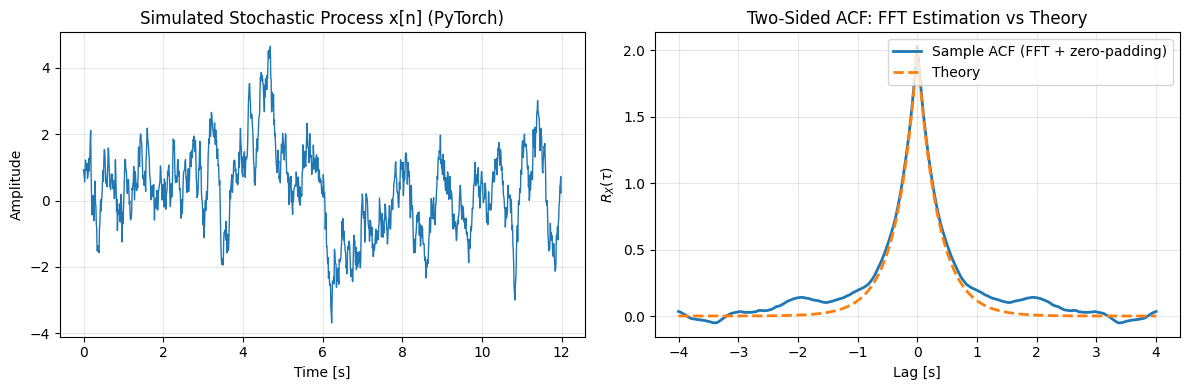

In [9]:
import math
import torch
import matplotlib.pyplot as plt


def forgetting_factor_from_tau_corr(
    dt_s: float,  # Sampling period [s]
    tau_corr_s: float,  # Correlation time constant [s]
) -> float:  # Discrete forgetting factor lambda in (0, 1)
    """Converts a continuous-time exponential decay constant into a discrete forgetting factor.

    Purpose:
        Map R_X(tau)=sigma_X^2*exp(-|tau|/tau_corr_s) to R_X[k]=sigma_X^2*lambda^|k|
        under uniform sampling with period dt_s.

    Parameters:
        dt_s: Sampling period in seconds.
        tau_corr_s: Correlation time constant in seconds.

    Returns:
        Forgetting factor lambda = exp(-dt_s/tau_corr_s).

    Side effects:
        None.
    """
    if dt_s <= 0.0:
        raise ValueError("dt_s must be strictly positive.")
    if tau_corr_s <= 0.0:
        raise ValueError("tau_corr_s must be strictly positive.")

    return float(math.exp(-dt_s / tau_corr_s))


def simulate_exponential_acf_process_torch(
    n_samples: int,  # Number of samples N [samples]
    sigma_x2: float,  # Target process variance sigma_X^2
    lambda_forgetting: float,  # AR(1) forgetting factor lambda
    seed: int = 7,  # RNG seed for deterministic simulation
    dtype: torch.dtype = torch.float64,  # Numeric precision used by torch
    device: str = "cpu",  # Execution device ("cpu" or CUDA device)
) -> torch.Tensor:  # Simulated stationary process x[n]
    """Generates a stationary Gaussian AR(1) process with the target exponential ACF.

    Purpose:
        Simulate x[n] satisfying approximately R_X[k]=sigma_X^2*lambda_forgetting^|k|
        by using x[n]=lambda*x[n-1]+w[n] with properly scaled innovations.

    Parameters:
        n_samples: Output length in samples.
        sigma_x2: Target stationary variance (must be non-negative).
        lambda_forgetting: AR(1) coefficient in [0, 1).
        seed: Seed controlling random draws.
        dtype: Torch floating dtype for outputs and intermediate arrays.
        device: Device where tensors are allocated.

    Returns:
        1D tensor x[n] with length n_samples.

    Side effects:
        Uses torch pseudorandom number generation.

    Assumptions:
        For exact stationarity from n=0, x[0] is sampled from N(0, sigma_x2).
    """
    if n_samples < 2:
        raise ValueError("n_samples must be at least 2.")
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")
    if not (0.0 <= lambda_forgetting < 1.0):
        raise ValueError("lambda_forgetting must satisfy 0 <= lambda < 1.")

    # Match stationary AR(1) variance: sigma_W^2 = sigma_X^2 * (1 - lambda^2).
    sigma_w: float = math.sqrt(sigma_x2 * (1.0 - lambda_forgetting**2))

    # Create an explicit generator to keep randomness reproducible.
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)

    x_n = torch.empty(n_samples, dtype=dtype, device=device)

    # Draw initial state from the stationary marginal distribution.
    x_n[0] = torch.randn(1, dtype=dtype, device=device, generator=generator)[0] * math.sqrt(sigma_x2)

    # Draw all innovations and run the AR(1) recursion in time order.
    w_n = torch.randn(n_samples, dtype=dtype, device=device, generator=generator) * sigma_w
    for n in range(1, n_samples):
        x_n[n] = lambda_forgetting * x_n[n - 1] + w_n[n]

    return x_n


def next_power_of_two(
    value: int,  # Positive integer target value
) -> int:  # Smallest power-of-two >= value
    """Returns the smallest power-of-two greater than or equal to a target integer.

    Purpose:
        Choose an FFT length that is both efficient and large enough for linear
        autocorrelation recovery when zero-padding is required.

    Parameters:
        value: Minimum required FFT length.

    Returns:
        Power-of-two integer L satisfying L >= value.

    Side effects:
        None.
    """
    if value < 1:
        raise ValueError("value must be >= 1.")

    return 1 << (value - 1).bit_length()


def estimate_biased_acf_fft_zero_padding_two_sided_torch(
    x_n: torch.Tensor,  # Input sequence x[n]
    max_lag_samples: int,  # Maximum absolute lag k_max [samples]
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:  # (lags[k], two-sided ACF, non-negative ACF)
    """Estimates two-sided ACF via FFT with zero-padding to recover linear correlation.

    Purpose:
        Compute a biased sample ACF from one realization x[n] using
        Wiener-Khinchin with explicit zero-padding L >= 2N-1, then return
        lags from -k_max to +k_max.

    Parameters:
        x_n: 1D real tensor containing the time-domain realization.
        max_lag_samples: Largest absolute lag included in the estimate.

    Returns:
        lags_samples: Integer lag axis from -k_max to +k_max [samples].
        r_hat_two_sided: Biased ACF estimate aligned with lags_samples.
        r_hat_nonnegative: Biased ACF estimate for lags 0..k_max.

    Side effects:
        None.

    Assumptions:
        x_n is real-valued; empirical mean is removed before estimation.
    """
    if x_n.ndim != 1:
        raise ValueError("x_n must be a 1D tensor.")

    n_samples: int = int(x_n.numel())
    if not (0 <= max_lag_samples < n_samples):
        raise ValueError("max_lag_samples must be in [0, n_samples - 1].")

    # Remove empirical mean to estimate covariance-based ACF.
    x_centered = x_n - torch.mean(x_n)

    # Use L >= 2N-1 to avoid circular wrap-around and recover linear ACF.
    n_fft_min: int = 2 * n_samples - 1
    n_fft: int = next_power_of_two(n_fft_min)

    # Apply Wiener-Khinchin: R = IFFT{|FFT(x)|^2}.
    x_fft = torch.fft.rfft(x_centered, n=n_fft)
    spectrum = x_fft * torch.conj(x_fft)
    r_circular = torch.fft.irfft(spectrum, n=n_fft)

    # Extract lags -(k_max..1) from tail and (0..k_max) from head.
    r_negative = r_circular[n_fft - max_lag_samples : n_fft]
    r_nonnegative = r_circular[: max_lag_samples + 1]

    # Build two-sided ACF using biased normalization by N.
    r_hat_two_sided = torch.cat((r_negative, r_nonnegative), dim=0) / n_samples
    r_hat_nonnegative = r_nonnegative / n_samples

    lags_samples = torch.arange(
        -max_lag_samples,
        max_lag_samples + 1,
        dtype=torch.int64,
        device=x_n.device,
    )

    return lags_samples, r_hat_two_sided, r_hat_nonnegative


def estimate_exponential_acf_parameters_from_fft(
    r_hat_nonnegative: torch.Tensor,  # ACF estimate for k=0..k_max
    dt_s: float,  # Sampling period [s]
    fit_lag_max_samples: int,  # Maximum lag used in regression [samples]
    eps: float = 1.0e-12,  # Positivity threshold for log(.)
) -> tuple[float, float, float]:  # (sigma_x2_hat, lambda_hat, tau_corr_hat_s)
    """Estimates exponential ACF parameters from FFT-based non-negative lag estimates.

    Purpose:
        Fit log(R_hat[k]) = a + b * tau_k and recover sigma_x2, lambda, and tau_corr_s.

    Parameters:
        r_hat_nonnegative: Biased ACF estimate for k >= 0.
        dt_s: Sampling period in seconds.
        fit_lag_max_samples: Largest lag used in the linearized fit.
        eps: Minimum allowed ACF value for applying log.

    Returns:
        sigma_x2_hat: Estimated variance parameter.
        lambda_hat: Estimated forgetting factor.
        tau_corr_hat_s: Estimated correlation time constant [s].

    Side effects:
        None.

    Assumptions:
        The fitted segment behaves approximately as an exponential decay.
    """
    if r_hat_nonnegative.ndim != 1:
        raise ValueError("r_hat_nonnegative must be a 1D tensor.")
    if dt_s <= 0.0:
        raise ValueError("dt_s must be strictly positive.")

    n_available_lags: int = int(r_hat_nonnegative.numel())
    if not (1 <= fit_lag_max_samples < n_available_lags):
        raise ValueError("fit_lag_max_samples must be in [1, n_available_lags - 1].")

    # Select the fitting window over non-negative lags.
    lag_samples = torch.arange(
        fit_lag_max_samples + 1,
        dtype=r_hat_nonnegative.dtype,
        device=r_hat_nonnegative.device,
    )
    tau_s = lag_samples * dt_s
    r_fit = r_hat_nonnegative[: fit_lag_max_samples + 1]

    # Keep only positive ACF points so log(.) is defined.
    positive_mask = r_fit > eps
    if int(torch.sum(positive_mask).item()) < 2:
        raise ValueError("Not enough positive ACF points for log-linear fitting.")

    tau_fit_s = tau_s[positive_mask]
    y_log = torch.log(r_fit[positive_mask])

    # Solve least-squares for y = a + b*tau.
    ones = torch.ones_like(tau_fit_s)
    design_matrix = torch.stack((ones, tau_fit_s), dim=1)
    theta = torch.linalg.lstsq(design_matrix, y_log).solution

    a_hat = float(theta[0].item())
    b_hat = float(theta[1].item())

    sigma_x2_hat = float(math.exp(a_hat))

    # Convert fitted slope to tau_corr and lambda.
    if b_hat >= 0.0:
        tau_corr_hat_s = float("inf")
        lambda_hat = 1.0
    else:
        tau_corr_hat_s = -1.0 / b_hat
        lambda_hat = float(math.exp(-dt_s / tau_corr_hat_s))

    return sigma_x2_hat, lambda_hat, tau_corr_hat_s


# Configure target ACF and simulation controls.
sigma_x2: float = 2.0
tau_corr_s: float = 0.35
dt_s: float = 0.01
n_samples: int = 50_000
max_lag_samples: int = 400
fit_lag_max_samples: int = 40
seed: int = 1

lambda_forgetting = forgetting_factor_from_tau_corr(dt_s=dt_s, tau_corr_s=tau_corr_s)

# Simulate one time-domain realization x[n].
x_n = simulate_exponential_acf_process_torch(
    n_samples=n_samples,
    sigma_x2=sigma_x2,
    lambda_forgetting=lambda_forgetting,
    seed=seed,
)

# Estimate two-sided ACF from x[n] using FFT + zero-padding.
lags_samples, r_hat_two_sided, r_hat_nonnegative = estimate_biased_acf_fft_zero_padding_two_sided_torch(
    x_n=x_n,
    max_lag_samples=max_lag_samples,
)

# Estimate exponential ACF parameters from the FFT-based non-negative lags.
sigma_x2_hat, lambda_hat, tau_corr_hat_s = estimate_exponential_acf_parameters_from_fft(
    r_hat_nonnegative=r_hat_nonnegative,
    dt_s=dt_s,
    fit_lag_max_samples=fit_lag_max_samples,
)

# Build theory curves and physical lag axis.
lags_abs = torch.abs(lags_samples).to(dtype=x_n.dtype)
r_theory_two_sided = sigma_x2 * (lambda_forgetting ** lags_abs)
lag_s = lags_samples.to(dtype=x_n.dtype) * dt_s

# Print global summary and estimated parameters.
print(f"True parameters: sigma_X^2={sigma_x2:.6f}, lambda={lambda_forgetting:.6f}, tau_c={tau_corr_s:.6f} s")
print(f"Estimated from FFT ACF: sigma_X^2_hat={sigma_x2_hat:.6f}, lambda_hat={lambda_hat:.6f}, tau_c_hat={tau_corr_hat_s:.6f} s")
print(f"Sample variance (torch): {torch.var(x_n, unbiased=False).item():.6f}")

# Print two-sided ACF values around zero lag (both negative and positive lags).
print_lag_samples: int = 10
if print_lag_samples > max_lag_samples:
    print_lag_samples = max_lag_samples

center_index = max_lag_samples
start_index = center_index - print_lag_samples
end_index = center_index + print_lag_samples + 1

lags_to_print = lags_samples[start_index:end_index].cpu().tolist()
lag_s_to_print = lag_s[start_index:end_index].cpu().tolist()
acf_to_print = r_hat_two_sided[start_index:end_index].cpu().tolist()

print("\nTwo-sided FFT-based ACF samples:")
for lag_k, lag_tau_s, acf_value in zip(lags_to_print, lag_s_to_print, acf_to_print):
    print(f"  k={lag_k:+4d}, tau={lag_tau_s:+.4f} s, R_hat={acf_value:.6f}")

# Move tensors to CPU/NumPy for plotting with matplotlib.
time_s = torch.arange(n_samples, dtype=x_n.dtype, device=x_n.device) * dt_s
n_time_plot_samples: int = 1200

time_s_np = time_s[:n_time_plot_samples].cpu().numpy()
x_n_np = x_n[:n_time_plot_samples].cpu().numpy()
lag_s_np = lag_s.cpu().numpy()
r_hat_two_sided_np = r_hat_two_sided.cpu().numpy()
r_theory_two_sided_np = r_theory_two_sided.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: time-domain realization.
axes[0].plot(time_s_np, x_n_np, lw=1.0)
axes[0].set_title("Simulated Stochastic Process x[n] (PyTorch)")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Amplitude")
axes[0].grid(alpha=0.3)

# Right panel: two-sided FFT-based ACF estimate and theoretical ACF.
axes[1].plot(lag_s_np, r_hat_two_sided_np, lw=2.0, label="Sample ACF (FFT + zero-padding)")
axes[1].plot(lag_s_np, r_theory_two_sided_np, "--", lw=2.0, label="Theory")
axes[1].set_title("Two-Sided ACF: FFT Estimation vs Theory")
axes[1].set_xlabel("Lag [s]")
axes[1].set_ylabel(r"$R_X(\tau)$")
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.tight_layout()
plt.show()


Process mean: mu_X = 0.000000
Target variance: sigma_X^2 = 2.000000
ACF at zero lag: R_X(0) = 2.000000


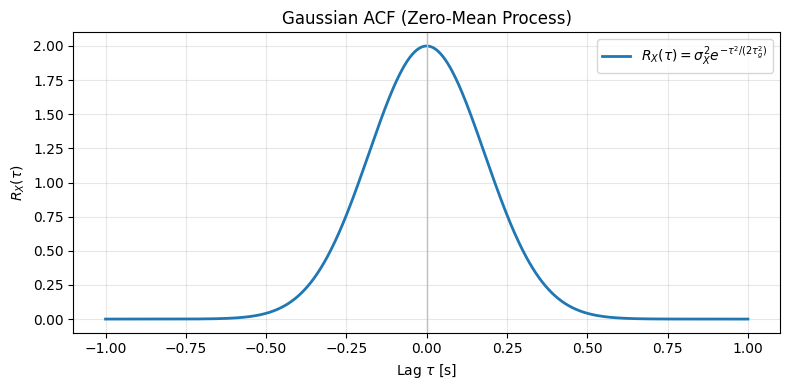

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def gaussian_acf(
    tau_s: np.ndarray,  # Lag values [s]
    sigma_x2: float,  # Process variance sigma_X^2
    tau_gauss_s: float,  # Gaussian ACF width parameter [s]
) -> np.ndarray:  # Gaussian ACF values R_X(tau)
    """Computes a Gaussian ACF model for a zero-mean process.

    Purpose:
        Evaluate R_X(tau) = sigma_X^2 * exp(-tau^2 / (2*tau_gauss_s^2)).

    Parameters:
        tau_s: Lag axis in seconds.
        sigma_x2: Process variance (must be non-negative).
        tau_gauss_s: Correlation-width parameter (must be strictly positive).

    Returns:
        Gaussian ACF samples with the same shape as tau_s.

    Side effects:
        None.
    """
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")
    if tau_gauss_s <= 0.0:
        raise ValueError("tau_gauss_s must be strictly positive.")

    # For a zero-mean process, ACF equals autocovariance.
    exponent = -(tau_s**2) / (2.0 * tau_gauss_s**2)
    return sigma_x2 * np.exp(exponent)


# Configure Gaussian ACF parameters.
mean_x: float = 0.0
sigma_x2: float = 2.0
tau_gauss_s: float = 0.18
tau_max_s: float = 1.0
n_lags: int = 801

# Generate a two-sided lag axis and evaluate Gaussian ACF.
tau_s = np.linspace(-tau_max_s, tau_max_s, n_lags)
r_x_tau = gaussian_acf(tau_s=tau_s, sigma_x2=sigma_x2, tau_gauss_s=tau_gauss_s)

print(f"Process mean: mu_X = {mean_x:.6f}")
print(f"Target variance: sigma_X^2 = {sigma_x2:.6f}")
print(f"ACF at zero lag: R_X(0) = {r_x_tau[n_lags // 2]:.6f}")

# Plot Gaussian ACF over negative and positive lags.
plt.figure(figsize=(8, 4))
plt.plot(tau_s, r_x_tau, lw=2, label=r"$R_X(\tau)=\sigma_X^2 e^{-\tau^2/(2\tau_g^2)}$")
plt.axvline(0.0, color="0.75", lw=1)
plt.xlabel(r"Lag $\tau$ [s]")
plt.ylabel(r"$R_X(\tau)$")
plt.title("Gaussian ACF (Zero-Mean Process)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Gaussian ACF Process: Time-Domain Generation + FFT-Based ACF Estimation

Target ACF for a zero-mean process:

$$
R_X(\tau) = \sigma_X^2 \exp\!\left(-\frac{\tau^2}{2\tau_g^2}\right).
$$

To synthesize a time-domain realization $x[n]$, we filter white Gaussian noise with a Gaussian FIR kernel.
The autocorrelation of a Gaussian kernel is also Gaussian, so the output process has approximately Gaussian ACF.

For ACF estimation from $x[n]$, we use FFT + zero-padding (linear, not circular):

$$
\hat{R}_X[k] = \frac{1}{N}\,\mathrm{IFFT}\!\left(\left|\mathrm{FFT}(x_0[n],L)\right|^2\right),
\quad x_0[n]=x[n]-\bar{x},
$$

with $L\ge 2N-1$. The estimator is then arranged into two-sided lags $k=-k_{\max},\dots,+k_{\max}$.

Parameter estimation (from non-negative lags) uses log-linear least squares:

$$
\log \hat{R}_X(\tau) = a + b\tau^2,
$$

so that

$$
\hat{\sigma}_X^2 = e^{\hat{a}}, \qquad \hat{\tau}_g = \sqrt{-\frac{1}{2\hat{b}}}.
$$

(Fit is restricted to early lags to reduce high-lag noise bias.)


True parameters: mean=0.000000, sigma_X^2=2.000000, tau_g=0.180000 s
Estimated from FFT ACF: sigma_X^2_hat=1.998831, tau_g_hat=0.180337 s
Sample mean (torch): -0.000000
Sample variance (torch): 2.000000

Two-sided FFT-based Gaussian ACF samples:
  k= -10, tau=-0.1000 s, R_hat=1.713411
  k=  -9, tau=-0.0900 s, R_hat=1.764329
  k=  -8, tau=-0.0800 s, R_hat=1.811197
  k=  -7, tau=-0.0700 s, R_hat=1.853614
  k=  -6, tau=-0.0600 s, R_hat=1.891207
  k=  -5, tau=-0.0500 s, R_hat=1.923643
  k=  -4, tau=-0.0400 s, R_hat=1.950632
  k=  -3, tau=-0.0300 s, R_hat=1.971930
  k=  -2, tau=-0.0200 s, R_hat=1.987341
  k=  -1, tau=-0.0100 s, R_hat=1.996727
  k=  +0, tau=+0.0000 s, R_hat=2.000000
  k=  +1, tau=+0.0100 s, R_hat=1.996727
  k=  +2, tau=+0.0200 s, R_hat=1.987341
  k=  +3, tau=+0.0300 s, R_hat=1.971930
  k=  +4, tau=+0.0400 s, R_hat=1.950632
  k=  +5, tau=+0.0500 s, R_hat=1.923643
  k=  +6, tau=+0.0600 s, R_hat=1.891207
  k=  +7, tau=+0.0700 s, R_hat=1.853614
  k=  +8, tau=+0.0800 s, R_hat=1.8

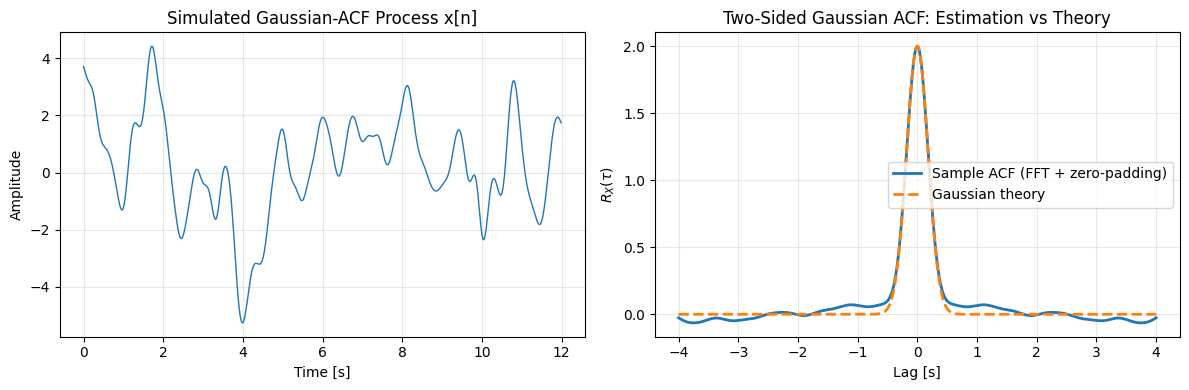

In [11]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def next_power_of_two(
    value: int,  # Positive integer target value
) -> int:  # Smallest power-of-two >= value
    """Returns the smallest power-of-two greater than or equal to a target integer.

    Purpose:
        Choose an FFT length that is efficient and large enough to recover
        linear autocorrelation with zero-padding.

    Parameters:
        value: Minimum required FFT length.

    Returns:
        Power-of-two integer L satisfying L >= value.

    Side effects:
        None.
    """
    if value < 1:
        raise ValueError("value must be >= 1.")

    return 1 << (value - 1).bit_length()


def build_gaussian_kernel_torch(
    dt_s: float,  # Sampling period [s]
    tau_gauss_s: float,  # Target Gaussian ACF width parameter [s]
    width_factor_sigma: float = 4.0,  # Half-support in kernel std-dev units
    dtype: torch.dtype = torch.float64,  # Numeric precision used by torch
    device: str = "cpu",  # Execution device
) -> torch.Tensor:  # L2-normalized Gaussian FIR kernel h[n]
    """Builds a Gaussian FIR kernel used to color white Gaussian noise.

    Purpose:
        Create a finite-support Gaussian kernel whose autocorrelation is
        approximately Gaussian, enabling simulation of a Gaussian-ACF process.

    Parameters:
        dt_s: Sampling period in seconds.
        tau_gauss_s: Target Gaussian ACF width parameter in seconds.
        width_factor_sigma: Truncation radius in standard deviations.
        dtype: Tensor dtype for kernel coefficients.
        device: Device where the kernel tensor is allocated.

    Returns:
        1D tensor containing an L2-normalized Gaussian kernel.

    Side effects:
        None.

    Assumptions:
        For Gaussian kernel h with standard deviation sigma_h,
        ACF width approximately follows tau_g ≈ sqrt(2) * sigma_h.
    """
    if dt_s <= 0.0:
        raise ValueError("dt_s must be strictly positive.")
    if tau_gauss_s <= 0.0:
        raise ValueError("tau_gauss_s must be strictly positive.")
    if width_factor_sigma <= 0.0:
        raise ValueError("width_factor_sigma must be strictly positive.")

    sigma_h_samples: float = tau_gauss_s / (dt_s * math.sqrt(2.0))
    half_support_samples: int = max(1, int(math.ceil(width_factor_sigma * sigma_h_samples)))

    n = torch.arange(
        -half_support_samples,
        half_support_samples + 1,
        dtype=dtype,
        device=device,
    )

    # Build Gaussian profile and normalize L2 energy so output variance is stable.
    h_n = torch.exp(-0.5 * (n / sigma_h_samples) ** 2)
    h_n = h_n / torch.linalg.norm(h_n)

    return h_n


def simulate_gaussian_acf_process_torch(
    n_samples: int,  # Number of output samples [samples]
    sigma_x2: float,  # Target process variance sigma_X^2
    dt_s: float,  # Sampling period [s]
    tau_gauss_s: float,  # Target Gaussian ACF width parameter [s]
    seed: int = 11,  # RNG seed for deterministic simulation
    dtype: torch.dtype = torch.float64,  # Numeric precision used by torch
    device: str = "cpu",  # Execution device
) -> torch.Tensor:  # Simulated process x[n]
    """Generates a zero-mean Gaussian process with approximately Gaussian ACF.

    Purpose:
        Produce one time-domain realization x[n] by filtering white Gaussian noise
        with a Gaussian FIR kernel, then scaling to the requested variance.

    Parameters:
        n_samples: Number of output samples.
        sigma_x2: Target variance (must be non-negative).
        dt_s: Sampling period in seconds.
        tau_gauss_s: Gaussian ACF width parameter in seconds.
        seed: Seed controlling random draws.
        dtype: Tensor dtype for simulation arrays.
        device: Device where tensors are allocated.

    Returns:
        1D tensor x[n] with length n_samples.

    Side effects:
        Uses torch pseudorandom number generation.
    """
    if n_samples < 2:
        raise ValueError("n_samples must be at least 2.")
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")

    h_n = build_gaussian_kernel_torch(
        dt_s=dt_s,
        tau_gauss_s=tau_gauss_s,
        width_factor_sigma=4.0,
        dtype=dtype,
        device=device,
    )

    kernel_len: int = int(h_n.numel())

    # Generate exactly enough white-noise samples for a full-overlap valid convolution.
    n_white_samples: int = n_samples + kernel_len - 1
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)
    w_n = torch.randn(n_white_samples, dtype=dtype, device=device, generator=generator)

    # Convolve in time domain to create colored process with Gaussian-like ACF.
    x_n = F.conv1d(
        w_n.view(1, 1, -1),
        torch.flip(h_n, dims=(0,)).view(1, 1, -1),
        padding=0,
    ).view(-1)

    # Enforce zero sample mean and target sample variance for this realization.
    x_n = x_n - torch.mean(x_n)
    var_x = torch.var(x_n, unbiased=False)
    if sigma_x2 == 0.0:
        return torch.zeros_like(x_n)
    if float(var_x.item()) <= 0.0:
        raise ValueError("Generated process variance is non-positive.")

    x_n = x_n * math.sqrt(sigma_x2 / float(var_x.item()))
    return x_n


def estimate_biased_acf_fft_zero_padding_two_sided_torch(
    x_n: torch.Tensor,  # Input sequence x[n]
    max_lag_samples: int,  # Maximum absolute lag k_max [samples]
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:  # (lags[k], two-sided ACF, non-negative ACF)
    """Estimates two-sided biased ACF using FFT and zero-padding.

    Purpose:
        Compute linear autocorrelation from one realization by Wiener-Khinchin,
        with explicit zero-padding so circular aliasing is avoided.

    Parameters:
        x_n: 1D real tensor containing the time-domain realization.
        max_lag_samples: Largest absolute lag returned.

    Returns:
        lags_samples: Integer lag axis from -k_max to +k_max [samples].
        r_hat_two_sided: Biased ACF estimate aligned with lags_samples.
        r_hat_nonnegative: Biased ACF estimate for lags 0..k_max.

    Side effects:
        None.
    """
    if x_n.ndim != 1:
        raise ValueError("x_n must be a 1D tensor.")

    n_samples: int = int(x_n.numel())
    if not (0 <= max_lag_samples < n_samples):
        raise ValueError("max_lag_samples must be in [0, n_samples - 1].")

    x_centered = x_n - torch.mean(x_n)

    n_fft = next_power_of_two(2 * n_samples - 1)
    x_fft = torch.fft.rfft(x_centered, n=n_fft)
    spectrum = x_fft * torch.conj(x_fft)
    r_circular = torch.fft.irfft(spectrum, n=n_fft)

    # Map circular output into linear negative/positive lags.
    r_negative = r_circular[n_fft - max_lag_samples : n_fft]
    r_nonnegative = r_circular[: max_lag_samples + 1]

    r_hat_two_sided = torch.cat((r_negative, r_nonnegative), dim=0) / n_samples
    r_hat_nonnegative = r_nonnegative / n_samples

    lags_samples = torch.arange(
        -max_lag_samples,
        max_lag_samples + 1,
        dtype=torch.int64,
        device=x_n.device,
    )

    return lags_samples, r_hat_two_sided, r_hat_nonnegative


def estimate_gaussian_acf_parameters_from_fft(
    r_hat_nonnegative: torch.Tensor,  # Estimated ACF for lags 0..k_max
    dt_s: float,  # Sampling period [s]
    fit_lag_max_samples: int,  # Largest lag used for fitting [samples]
    eps: float = 1.0e-12,  # Positivity threshold for log(.)
) -> tuple[float, float]:  # (sigma_x2_hat, tau_gauss_hat_s)
    """Estimates Gaussian ACF parameters from FFT-based non-negative lag estimates.

    Purpose:
        Fit log(R_hat(tau)) = a + b*tau^2 and recover sigma_x2 and tau_gauss_s.

    Parameters:
        r_hat_nonnegative: Biased ACF estimate for non-negative lags.
        dt_s: Sampling period in seconds.
        fit_lag_max_samples: Largest lag included in regression.
        eps: Minimum ACF value allowed for log-transform.

    Returns:
        sigma_x2_hat: Estimated variance parameter.
        tau_gauss_hat_s: Estimated Gaussian ACF width parameter [s].

    Side effects:
        None.
    """
    if r_hat_nonnegative.ndim != 1:
        raise ValueError("r_hat_nonnegative must be 1D.")
    if dt_s <= 0.0:
        raise ValueError("dt_s must be strictly positive.")

    n_available = int(r_hat_nonnegative.numel())
    if not (1 <= fit_lag_max_samples < n_available):
        raise ValueError("fit_lag_max_samples must be in [1, n_available - 1].")

    lags = torch.arange(
        fit_lag_max_samples + 1,
        dtype=r_hat_nonnegative.dtype,
        device=r_hat_nonnegative.device,
    )
    tau_s = lags * dt_s
    r_fit = r_hat_nonnegative[: fit_lag_max_samples + 1]

    positive_mask = r_fit > eps
    if int(torch.sum(positive_mask).item()) < 2:
        raise ValueError("Not enough positive ACF points for log-linear fitting.")

    tau_fit_s = tau_s[positive_mask]
    y_log = torch.log(r_fit[positive_mask])

    # Linear regression in tau^2: y = a + b * tau^2.
    z = tau_fit_s**2
    design_matrix = torch.stack((torch.ones_like(z), z), dim=1)
    theta = torch.linalg.lstsq(design_matrix, y_log).solution

    a_hat = float(theta[0].item())
    b_hat = float(theta[1].item())

    sigma_x2_hat = float(math.exp(a_hat))
    if b_hat >= 0.0:
        tau_gauss_hat_s = float("inf")
    else:
        tau_gauss_hat_s = float(math.sqrt(-1.0 / (2.0 * b_hat)))

    return sigma_x2_hat, tau_gauss_hat_s


# Configure Gaussian ACF process simulation and estimation controls.
mean_x: float = 0.0
sigma_x2: float = 2.0
tau_gauss_s: float = 0.18
dt_s: float = 0.01
n_samples: int = 50_000
max_lag_samples: int = 400
fit_lag_max_samples: int = 20
seed: int = 13

# Generate one time-domain realization x[n].
x_n = simulate_gaussian_acf_process_torch(
    n_samples=n_samples,
    sigma_x2=sigma_x2,
    dt_s=dt_s,
    tau_gauss_s=tau_gauss_s,
    seed=seed,
)

# Estimate ACF from x[n] using FFT + zero-padding.
lags_samples, r_hat_two_sided, r_hat_nonnegative = estimate_biased_acf_fft_zero_padding_two_sided_torch(
    x_n=x_n,
    max_lag_samples=max_lag_samples,
)

# Estimate Gaussian ACF parameters from the non-negative-lag estimate.
sigma_x2_hat, tau_gauss_hat_s = estimate_gaussian_acf_parameters_from_fft(
    r_hat_nonnegative=r_hat_nonnegative,
    dt_s=dt_s,
    fit_lag_max_samples=fit_lag_max_samples,
)

# Build theoretical two-sided ACF curve for comparison.
lag_s = lags_samples.to(dtype=x_n.dtype) * dt_s
r_theory_two_sided = sigma_x2 * torch.exp(-(lag_s**2) / (2.0 * tau_gauss_s**2))

print(f"True parameters: mean={mean_x:.6f}, sigma_X^2={sigma_x2:.6f}, tau_g={tau_gauss_s:.6f} s")
print(f"Estimated from FFT ACF: sigma_X^2_hat={sigma_x2_hat:.6f}, tau_g_hat={tau_gauss_hat_s:.6f} s")
print(f"Sample mean (torch): {torch.mean(x_n).item():.6f}")
print(f"Sample variance (torch): {torch.var(x_n, unbiased=False).item():.6f}")

# Print two-sided ACF values around zero lag (negative and positive lags).
print_lag_samples: int = 10
if print_lag_samples > max_lag_samples:
    print_lag_samples = max_lag_samples

center_index = max_lag_samples
start_index = center_index - print_lag_samples
end_index = center_index + print_lag_samples + 1

lags_to_print = lags_samples[start_index:end_index].cpu().tolist()
lag_s_to_print = lag_s[start_index:end_index].cpu().tolist()
acf_to_print = r_hat_two_sided[start_index:end_index].cpu().tolist()

print("\nTwo-sided FFT-based Gaussian ACF samples:")
for lag_k, lag_tau_s, acf_value in zip(lags_to_print, lag_s_to_print, acf_to_print):
    print(f"  k={lag_k:+4d}, tau={lag_tau_s:+.4f} s, R_hat={acf_value:.6f}")

# Plot time-domain realization and ACF estimation results.
n_time_plot_samples: int = 1200

time_s = torch.arange(n_samples, dtype=x_n.dtype, device=x_n.device) * dt_s

time_s_np = time_s[:n_time_plot_samples].cpu().numpy()
x_n_np = x_n[:n_time_plot_samples].cpu().numpy()
lag_s_np = lag_s.cpu().numpy()
r_hat_two_sided_np = r_hat_two_sided.cpu().numpy()
r_theory_two_sided_np = r_theory_two_sided.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: time-domain stochastic process realization.
axes[0].plot(time_s_np, x_n_np, lw=1.0)
axes[0].set_title("Simulated Gaussian-ACF Process x[n]")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Amplitude")
axes[0].grid(alpha=0.3)

# Right panel: FFT-based two-sided ACF estimate versus Gaussian theory.
axes[1].plot(lag_s_np, r_hat_two_sided_np, lw=2.0, label="Sample ACF (FFT + zero-padding)")
axes[1].plot(lag_s_np, r_theory_two_sided_np, "--", lw=2.0, label="Gaussian theory")
axes[1].set_title("Two-Sided Gaussian ACF: Estimation vs Theory")
axes[1].set_xlabel("Lag [s]")
axes[1].set_ylabel(r"$R_X(\tau)$")
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.tight_layout()
plt.show()


## Wiener-Khinchin PSD Estimation from the ACF

For a wide-sense stationary process, the Wiener-Khinchin theorem states that the power spectral density (PSD) is the Fourier transform of the autocorrelation function (ACF):

$$
S_X(f) = \int_{-\infty}^{\infty} R_X(\tau) e^{-j2\pi f \tau} \, d\tau.
$$

In discrete-time (sample period $\Delta t$), using an estimated two-sided ACF $\hat R_X[k]$, we apply FFT to approximate this transform:

$$
\hat S_X(f_m) \approx \Delta t \sum_{k=-K}^{K} \hat R_X[k] e^{-j2\pi f_m k\Delta t}.
$$

The code uses the FFT implementation of this sum after arranging negative and positive lags consistently and zero-padding for frequency resolution.

Consistency check (continuous-frequency convention):

$$
R_X(0) = \int S_X(f) \, df.
$$


### Analytical PSD of a Gaussian ACF

If

$$
R_X(\tau) = \sigma_X^2 \exp\!\left(-\frac{\tau^2}{2\tau_g^2}\right),
$$

then its Fourier transform is also Gaussian:

$$
S_X(f) = \sigma_X^2 \tau_g \sqrt{2\pi}\,\exp\!\left(-2\pi^2 \tau_g^2 f^2\right).
$$

So we expect the PSD estimated via Wiener-Khinchin from the FFT-based ACF to follow this Gaussian spectral envelope.


R_hat(0) from ACF = 2.000000
Integral of PSD estimate = 2.000003


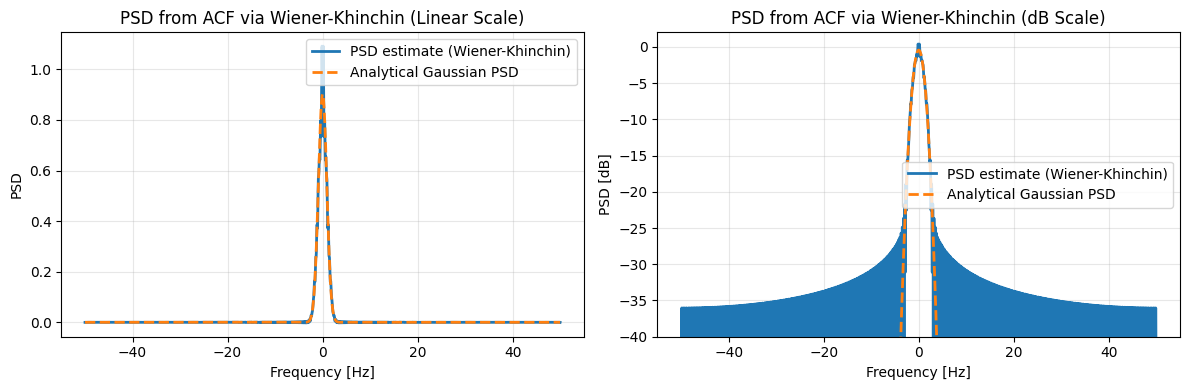

In [12]:
import math
import torch
import matplotlib.pyplot as plt


def next_power_of_two(
    value: int,  # Positive integer target value
) -> int:  # Smallest power-of-two >= value
    """Returns the smallest power-of-two greater than or equal to a target integer."""
    if value < 1:
        raise ValueError("value must be >= 1.")
    return 1 << (value - 1).bit_length()


def estimate_psd_from_two_sided_acf_wiener_khinchin_torch(
    r_hat_two_sided: torch.Tensor,  # ACF estimate for lags -K..+K
    dt_s: float,  # Sampling period [s]
    n_fft: int | None = None,  # FFT size for spectral sampling
) -> tuple[torch.Tensor, torch.Tensor]:  # (frequency_hz, PSD estimate)
    """Estimates PSD from a two-sided ACF using Wiener-Khinchin.

    Purpose:
        Compute S_X(f) by FFT of the estimated two-sided ACF sequence and
        return a centered frequency grid in Hz.

    Parameters:
        r_hat_two_sided: 1D tensor ordered as lags [-K, ..., 0, ..., +K].
        dt_s: Sampling period in seconds.
        n_fft: Optional FFT length. If None, selected automatically.

    Returns:
        frequency_hz: Centered frequency axis in Hz (ascending).
        psd_hat: Centered PSD estimate aligned with frequency_hz.

    Side effects:
        None.
    """
    if r_hat_two_sided.ndim != 1:
        raise ValueError("r_hat_two_sided must be a 1D tensor.")
    if dt_s <= 0.0:
        raise ValueError("dt_s must be strictly positive.")

    n_lags_total: int = int(r_hat_two_sided.numel())
    if n_lags_total % 2 == 0:
        raise ValueError("r_hat_two_sided length must be odd (for symmetric -K..+K lags).")

    k_max: int = (n_lags_total - 1) // 2

    # Arrange lag sequence into FFT order with lag 0 at index 0.
    if n_fft is None:
        n_fft = next_power_of_two(max(2048, 8 * n_lags_total))
    if n_fft < n_lags_total:
        raise ValueError("n_fft must be >= len(r_hat_two_sided).")

    r_for_fft = torch.zeros(n_fft, dtype=r_hat_two_sided.dtype, device=r_hat_two_sided.device)
    r_for_fft[0 : k_max + 1] = r_hat_two_sided[k_max:]  # lags 0..+K
    r_for_fft[n_fft - k_max : n_fft] = r_hat_two_sided[:k_max]  # lags -K..-1

    # Wiener-Khinchin discrete approximation: S(f) ≈ dt * FFT{R[k]}.
    psd_complex = dt_s * torch.fft.fft(r_for_fft, n=n_fft)
    psd_real = torch.real(psd_complex)

    frequency_hz = torch.fft.fftfreq(n_fft, d=dt_s)

    # Center both frequency and PSD for plotting in [-fs/2, fs/2).
    frequency_hz = torch.fft.fftshift(frequency_hz)
    psd_real = torch.fft.fftshift(psd_real)

    return frequency_hz, psd_real


def gaussian_analytic_psd_hz(
    frequency_hz: torch.Tensor,  # Frequency axis [Hz]
    sigma_x2: float,  # Process variance sigma_X^2
    tau_gauss_s: float,  # Gaussian ACF width parameter [s]
) -> torch.Tensor:  # Analytical PSD S_X(f)
    """Evaluates the analytical Gaussian PSD from the Gaussian ACF model."""
    if sigma_x2 < 0.0:
        raise ValueError("sigma_x2 must be non-negative.")
    if tau_gauss_s <= 0.0:
        raise ValueError("tau_gauss_s must be strictly positive.")

    coefficient = sigma_x2 * tau_gauss_s * math.sqrt(2.0 * math.pi)
    exponent = -2.0 * (math.pi**2) * (tau_gauss_s**2) * (frequency_hz**2)
    return coefficient * torch.exp(exponent)


# Ensure Gaussian ACF simulation/estimation cell was executed first.
if "r_hat_two_sided" not in globals() or "dt_s" not in globals():
    raise RuntimeError(
        "Run the Gaussian process cell (acf-gaussian-process-simulation-fft) first "
        "to define r_hat_two_sided, dt_s, sigma_x2, and tau_gauss_s."
    )

sigma_x2_model: float = float(sigma_x2)
tau_gauss_model_s: float = float(tau_gauss_s)

# Estimate PSD via Wiener-Khinchin from the estimated two-sided ACF.
frequency_hz, psd_hat = estimate_psd_from_two_sided_acf_wiener_khinchin_torch(
    r_hat_two_sided=r_hat_two_sided,
    dt_s=float(dt_s),
    n_fft=None,
)

# Compute analytical PSD for comparison.
psd_analytic = gaussian_analytic_psd_hz(
    frequency_hz=frequency_hz,
    sigma_x2=sigma_x2_model,
    tau_gauss_s=tau_gauss_model_s,
)

# Numerical consistency check: integral of PSD should approximate R(0).
power_from_psd = torch.trapz(psd_hat, frequency_hz).item()
r0_from_acf = float(r_hat_two_sided[len(r_hat_two_sided) // 2].item())
print(f"R_hat(0) from ACF = {r0_from_acf:.6f}")
print(f"Integral of PSD estimate = {power_from_psd:.6f}")

# Convert to NumPy for plotting and use floor for stable dB display.
frequency_hz_np = frequency_hz.cpu().numpy()
psd_hat_np = psd_hat.cpu().numpy()
psd_analytic_np = psd_analytic.cpu().numpy()

psd_floor = 1.0e-12
psd_hat_db = 10.0 * torch.log10(torch.clamp(psd_hat, min=psd_floor)).cpu().numpy()
psd_analytic_db = 10.0 * torch.log10(torch.clamp(psd_analytic, min=psd_floor)).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Linear-scale PSD comparison.
axes[0].plot(frequency_hz_np, psd_hat_np, lw=2, label="PSD estimate (Wiener-Khinchin)")
axes[0].plot(frequency_hz_np, psd_analytic_np, "--", lw=2, label="Analytical Gaussian PSD")
axes[0].set_title("PSD from ACF via Wiener-Khinchin (Linear Scale)")
axes[0].set_xlabel("Frequency [Hz]")
axes[0].set_ylabel("PSD")
axes[0].grid(alpha=0.3)
axes[0].legend()

# dB-scale PSD comparison.
axes[1].plot(frequency_hz_np, psd_hat_db, lw=2, label="PSD estimate (Wiener-Khinchin)")
axes[1].plot(frequency_hz_np, psd_analytic_db, "--", lw=2, label="Analytical Gaussian PSD")
axes[1].set_title("PSD from ACF via Wiener-Khinchin (dB Scale)")
axes[1].set_xlabel("Frequency [Hz]")
axes[1].set_ylabel("PSD [dB]")
axes[1].set_ylim(-40.0, 2.0)
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.tight_layout()
plt.show()


## ACF as Sum of Two Gaussian Terms

Using your specification with $K\in\{0,1\}$:

$$
R_X(\tau)=\sum_{K=0}^{1}\frac{1}{K+1}\,\mathcal{N}\!\left(\tau;\,K,\,\frac{\sigma_X^2}{K+1}\right),
$$

where $\mathcal{N}(\tau;\mu,v)$ is the Gaussian pdf with mean $\mu$ and variance $v$.

Expanded form:

$$
R_X(\tau)=\mathcal{N}(\tau;0,\sigma_X^2)+\frac{1}{2}\,\mathcal{N}\!\left(\tau;1,\frac{\sigma_X^2}{2}\right).
$$


sigma_X^2 = 2.000000
Max |R_X(tau)-R_X(-tau)| on grid = 1.777840e-01
Min Re{FFT[R_X]} on grid = -6.115819e-04


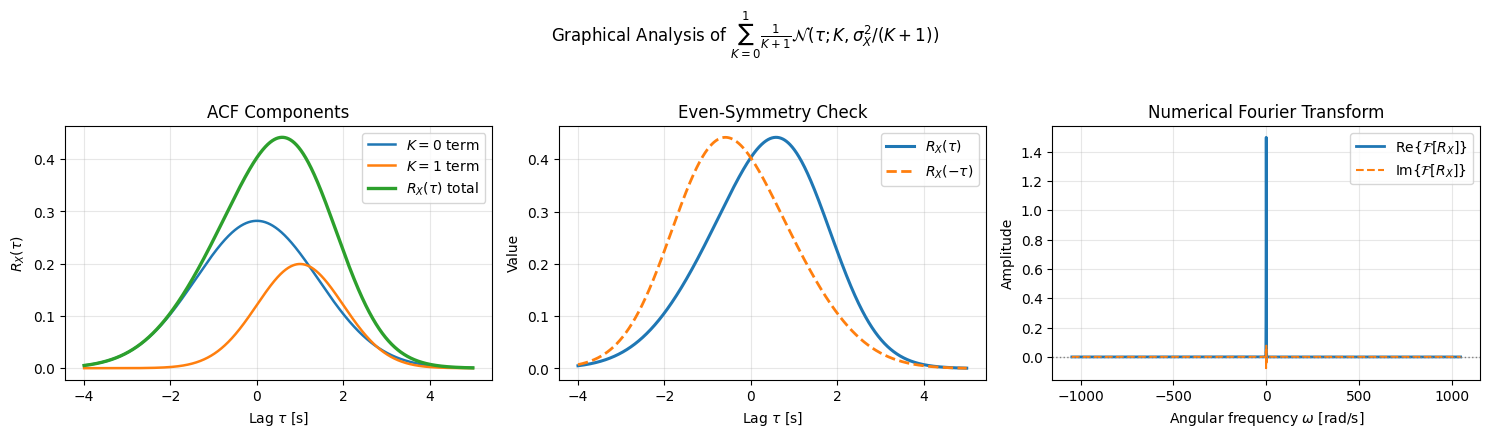

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def gaussian_pdf(
    tau_s: np.ndarray,          # Lag axis [s]
    mean_s: float,              # Gaussian mean [s]
    variance_s2: float,         # Gaussian variance [s^2]
) -> np.ndarray:                # Gaussian pdf evaluated on tau_s
    """Evaluates the Gaussian pdf N(tau; mean, variance) over a lag axis."""
    if variance_s2 <= 0.0:
        raise ValueError("variance_s2 must be strictly positive.")

    normalization = 1.0 / np.sqrt(2.0 * np.pi * variance_s2)
    exponent = -0.5 * ((tau_s - mean_s) ** 2) / variance_s2
    return normalization * np.exp(exponent)


def weighted_two_term_acf(
    tau_s: np.ndarray,          # Lag axis [s]
    sigma_x2: float,            # Variance scale sigma_X^2 [s^2]
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:  # (K=0 term, K=1 term, total)
    """Builds R_X(tau)=sum_{K=0}^1 (1/(K+1))*N(tau; K, sigma_x2/(K+1)).

    Purpose:
        Construct the exact two-term ACF candidate requested in the markdown
        and return each contribution plus the total curve.

    Parameters:
        tau_s: Lag samples where the model is evaluated.
        sigma_x2: Positive variance scale of the model.

    Returns:
        term_k0: Contribution for K=0.
        term_k1: Contribution for K=1.
        acf_total: Sum term_k0 + term_k1.

    Side effects:
        None.
    """
    if sigma_x2 <= 0.0:
        raise ValueError("sigma_x2 must be strictly positive.")

    # Build each Gaussian component exactly from the analytical definition.
    term_k0 = (1.0 / (0 + 1)) * gaussian_pdf(
        tau_s=tau_s,
        mean_s=0.0,
        variance_s2=sigma_x2 / (0 + 1),
    )
    term_k1 = (1.0 / (1 + 1)) * gaussian_pdf(
        tau_s=tau_s,
        mean_s=1.0,
        variance_s2=sigma_x2 / (1 + 1),
    )
    acf_total = term_k0 + term_k1
    return term_k0, term_k1, acf_total


# Configure lag and frequency axes for graphical analysis.
sigma_x2: float = 2.0
tau_min_s: float = -4.0
tau_max_s: float = 5.0
n_tau: int = 3001

tau_s = np.linspace(tau_min_s, tau_max_s, n_tau)
delta_tau_s = tau_s[1] - tau_s[0]

term_k0, term_k1, r_tau = weighted_two_term_acf(
    tau_s=tau_s,
    sigma_x2=sigma_x2,
)
_, _, r_minus_tau = weighted_two_term_acf(
    tau_s=-tau_s,
    sigma_x2=sigma_x2,
)

# Use FFT as a numerical Fourier transform to inspect PSD-related behavior.
omega_rad_s = 2.0 * np.pi * np.fft.fftshift(np.fft.fftfreq(n_tau, d=delta_tau_s))
spectrum = delta_tau_s * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(r_tau)))

symmetry_error = np.max(np.abs(r_tau - r_minus_tau))
print(f"sigma_X^2 = {sigma_x2:.6f}")
print(f"Max |R_X(tau)-R_X(-tau)| on grid = {symmetry_error:.6e}")
print(f"Min Re{{FFT[R_X]}} on grid = {np.min(np.real(spectrum)):.6e}")

# Plot components, symmetry check, and numerical spectrum in a single view.
fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

axes[0].plot(tau_s, term_k0, lw=1.8, label=r"$K=0$ term")
axes[0].plot(tau_s, term_k1, lw=1.8, label=r"$K=1$ term")
axes[0].plot(tau_s, r_tau, lw=2.4, label=r"$R_X(\tau)$ total")
axes[0].set_title("ACF Components")
axes[0].set_xlabel(r"Lag $\tau$ [s]")
axes[0].set_ylabel(r"$R_X(\tau)$")
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(tau_s, r_tau, lw=2.2, label=r"$R_X(\tau)$")
axes[1].plot(tau_s, r_minus_tau, lw=2.0, linestyle='--', label=r"$R_X(-\tau)$")
axes[1].set_title("Even-Symmetry Check")
axes[1].set_xlabel(r"Lag $\tau$ [s]")
axes[1].set_ylabel(r"Value")
axes[1].grid(alpha=0.3)
axes[1].legend()

axes[2].plot(omega_rad_s, np.real(spectrum), lw=2.0, label=r"Re$\{\mathcal{F}[R_X]\}$")
axes[2].plot(omega_rad_s, np.imag(spectrum), lw=1.5, linestyle='--', label=r"Im$\{\mathcal{F}[R_X]\}$")
axes[2].axhline(0.0, color='0.5', lw=1.0, linestyle=':')
axes[2].set_title("Numerical Fourier Transform")
axes[2].set_xlabel(r"Angular frequency $\omega$ [rad/s]")
axes[2].set_ylabel("Amplitude")
axes[2].grid(alpha=0.3)
axes[2].legend()

fig.suptitle(r"Graphical Analysis of $\sum_{K=0}^{1}\frac{1}{K+1}\mathcal{N}(\tau;K,\sigma_X^2/(K+1))$", y=1.03)
fig.tight_layout()
plt.show()


### Analytical Validity Check of the Candidate ACF

Assume the model is interpreted as

$$
R_X(\tau)=\sum_{k\in\mathcal{K}}\mathcal{N}\!\left(\tau;\mu(k),\frac{\sigma_X^2}{k+1}\right),
$$

where $\mathcal{N}(\tau;m,v)$ is a Gaussian pdf in lag $\tau$.

For a real WSS process, a valid autocorrelation must satisfy:

1. $R_X(0)<\infty$ (finite signal power).
2. $R_X(\tau)=R_X(-\tau)$ (even symmetry).
3. Positive semidefiniteness (equivalently, nonnegative PSD).

**(a) $\mu(k)=0$ for every $k$**

$$
R_X(\tau)=\sum_{k\in\mathcal{K}}\mathcal{N}\!\left(\tau;0,\frac{\sigma_X^2}{k+1}\right).
$$

With finite $\mathcal{K}$ (your assumption) and well-defined variances $\sigma_X^2/(k+1)>0$, each term is even in $\tau$ and positive-definite; therefore the finite sum is a valid ACF.

**(b) $\mu(k)=k$ for $k\in\{0,1\}$**

$$
R_X(\tau)=\mathcal{N}(\tau;0,\sigma_X^2)+\mathcal{N}\!\left(\tau;1,\frac{\sigma_X^2}{2}\right).
$$

Then

$$
R_X(-\tau)=\mathcal{N}(\tau;0,\sigma_X^2)+\mathcal{N}\!\left(\tau;-1,\frac{\sigma_X^2}{2}\right)\neq R_X(\tau).
$$

It is not even, therefore **not** a valid ACF.

**(c) $\mu(k)=k$ for $k\in\{-10,0,10\}$**

At $k=-1$, the variance term is

$$
\frac{\sigma_X^2}{k+1}=\frac{\sigma_X^2}{0},
$$

which is undefined. Therefore the expression is not well-defined, hence it cannot be a valid ACF as written.

**Conclusion (with finite-$k$ assumption in case a):**

- (a) Valid.
- (b) Invalid.
- (c) Invalid (undefined term at $k=-1$).


### Analytical Validity Check with $\sigma_X^2/|k|!$

Now consider

$$
R_X(\tau)=\sum_{k\in\mathcal{K}}\mathcal{N}\!\left(\tau;\mu(k),\frac{\sigma_X^2}{|k|!}\right),
$$

with integer $k$ (so $|k|!$ is defined).

For a real WSS process, a valid ACF must be finite at $\tau=0$, even in $\tau$, and yield a nonnegative PSD.

**(a) $\mu(k)=0$ for every $k$ (finite $\mathcal{K}$)**

$$
R_X(\tau)=\sum_{k\in\mathcal{K}}\mathcal{N}\!\left(\tau;0,\frac{\sigma_X^2}{|k|!}\right).
$$

Each term is centered Gaussian, hence even and positive-definite. A finite sum preserves these properties, so this case is a valid ACF.

**(b) $\mu(k)=k$ for $k\in\{0,1\}$**

Since $|0|!=|1|!=1$,

$$
R_X(\tau)=\mathcal{N}(\tau;0,\sigma_X^2)+\mathcal{N}(\tau;1,\sigma_X^2).
$$

Then

$$
R_X(-\tau)=\mathcal{N}(\tau;0,\sigma_X^2)+\mathcal{N}(\tau;-1,\sigma_X^2)\neq R_X(\tau),
$$

so it is not even. Therefore it is not a valid real-valued ACF.

**(c) $\mu(k)=k$ for $k\in\{-10,0,10\}$**

Here $|-10|!=|10|!=10!$ and $|0|!=1$, so

$$
R_X(\tau)=\mathcal{N}\!\left(\tau;-10,\frac{\sigma_X^2}{10!}\right)+\mathcal{N}(\tau;0,\sigma_X^2)+\mathcal{N}\!\left(\tau;10,\frac{\sigma_X^2}{10!}\right).
$$

This is even, but PSD nonnegativity fails. The PSD is

$$
S_X(\omega)=e^{-\sigma_X^2\omega^2/2}+2\,e^{-\sigma_X^2\omega^2/(2\cdot 10!)}\cos(10\omega).
$$

At $\omega=\pi/10$, $\cos(10\omega)=\cos\pi=-1$, so

$$
S_X(\pi/10)=e^{-\sigma_X^2\pi^2/200}-2\,e^{-\sigma_X^2\pi^2/(200\cdot 10!)}<0
$$

(indeed for any $\sigma_X^2>0$). Hence this is not a valid ACF.

**Conclusion for the $\sigma_X^2/|k|!$ model:**

- (a) Valid (finite $\mathcal{K}$).
- (b) Invalid.
- (c) Invalid (negative PSD for some frequencies).


(a) $\mu(k)=0$, $\mathcal{K}=\{0,1,2,3\}$: max|R(tau)-R(-tau)|=0.000e+00, min Re{S(omega)}=3.714e-12, negative Re samples=0
(b) $\mu(k)=k$, $\mathcal{K}=\{0,1\}$: max|R(tau)-R(-tau)|=2.060e-01, min Re{S(omega)}=0.000e+00, negative Re samples=0
(c) $\mu(k)=k$, $\mathcal{K}=\{-10,0,10\}$: max|R(tau)-R(-tau)|=0.000e+00, min Re{S(omega)}=-2.000e+00, negative Re samples=1943


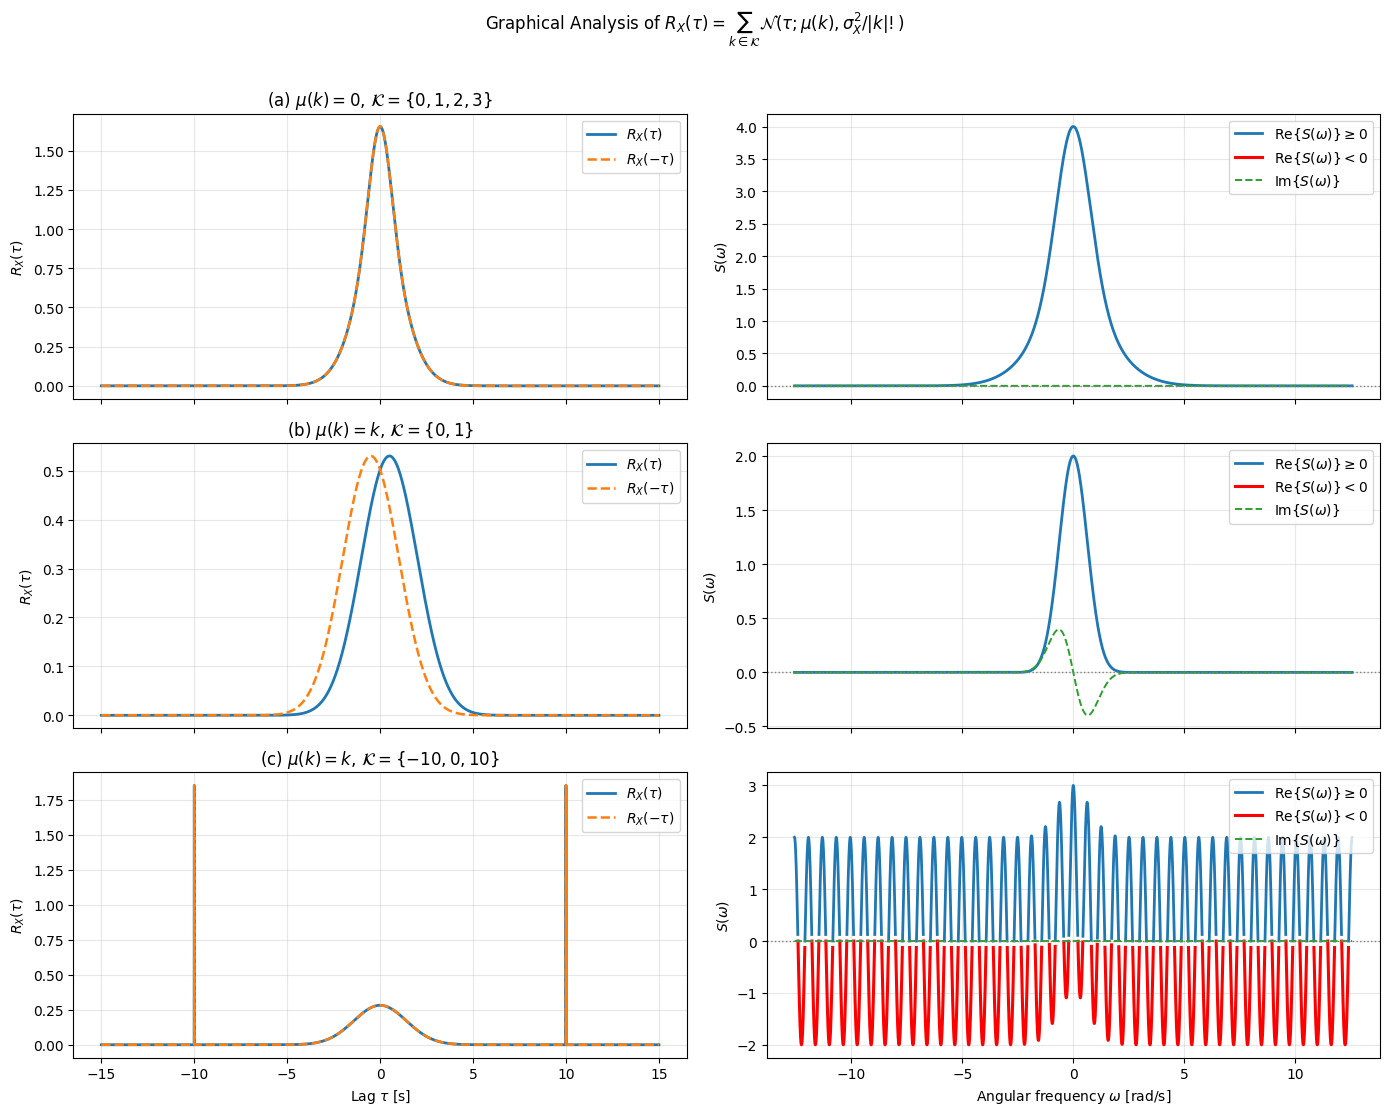

In [14]:
import math
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt


def gaussian_pdf(
    tau_s: np.ndarray,          # Lag axis [s]
    mean_s: float,              # Gaussian mean [s]
    variance_s2: float,         # Gaussian variance [s^2]
) -> np.ndarray:                # Gaussian pdf evaluated on tau_s
    """Evaluates the Gaussian pdf N(tau; mean, variance) over a lag axis."""
    if variance_s2 <= 0.0:
        raise ValueError("variance_s2 must be strictly positive.")

    normalization = 1.0 / np.sqrt(2.0 * np.pi * variance_s2)
    exponent = -0.5 * ((tau_s - mean_s) ** 2) / variance_s2
    return normalization * np.exp(exponent)


def factorial_variance_acf(
    tau_s: np.ndarray,                          # Lag axis [s]
    k_values: list[int],                        # Index set K
    sigma_x2: float,                            # Variance scale sigma_X^2 [s^2]
    mu_from_k: Callable[[int], float],          # Mapping k -> mu(k) [s]
) -> np.ndarray:                                # ACF samples R_X(tau)
    """Builds R_X(tau)=sum_{k in K} N(tau; mu(k), sigma_x2/|k|!).

    Purpose:
        Evaluate the factorial-variance Gaussian-sum ACF model directly on a
        lag grid for any finite integer set K and any user-defined mu(k).

    Parameters:
        tau_s: Lag samples where the model is evaluated.
        k_values: Finite integer index set K.
        sigma_x2: Positive variance scale.
        mu_from_k: Callable that returns mu(k) for each integer k.

    Returns:
        acf_total: Model samples of R_X(tau).

    Side effects:
        None.
    """
    if sigma_x2 <= 0.0:
        raise ValueError("sigma_x2 must be strictly positive.")

    acf_total = np.zeros_like(tau_s, dtype=np.float64)

    # Accumulate the Gaussian terms in the exact analytical form.
    for k in k_values:
        variance_k_s2 = sigma_x2 / math.factorial(abs(k))
        acf_total += gaussian_pdf(
            tau_s=tau_s,
            mean_s=float(mu_from_k(k)),
            variance_s2=variance_k_s2,
        )

    return acf_total


def factorial_variance_spectrum(
    omega_rad_s: np.ndarray,                    # Angular-frequency axis [rad/s]
    k_values: list[int],                        # Index set K
    sigma_x2: float,                            # Variance scale sigma_X^2 [s^2]
    mu_from_k: Callable[[int], float],          # Mapping k -> mu(k) [s]
) -> np.ndarray:                                # Fourier transform of R_X
    """Computes the analytical Fourier transform of the factorial-variance model.

    Purpose:
        Use the closed-form transform of each Gaussian term to inspect
        nonnegativity and imaginary parts in the spectrum domain.

    Parameters:
        omega_rad_s: Frequency samples in rad/s.
        k_values: Finite integer set K.
        sigma_x2: Positive variance scale.
        mu_from_k: Callable that returns mu(k).

    Returns:
        spectrum: Complex-valued Fourier transform samples.

    Side effects:
        None.
    """
    if sigma_x2 <= 0.0:
        raise ValueError("sigma_x2 must be strictly positive.")

    spectrum = np.zeros_like(omega_rad_s, dtype=np.complex128)

    # Sum closed-form transforms: exp(-0.5*v_k*omega^2) * exp(-j*mu(k)*omega).
    for k in k_values:
        variance_k_s2 = sigma_x2 / math.factorial(abs(k))
        mean_k_s = float(mu_from_k(k))
        spectrum += np.exp(-0.5 * variance_k_s2 * omega_rad_s**2) * np.exp(-1j * mean_k_s * omega_rad_s)

    return spectrum


# Configure common lag/frequency grids used for all subcases.
sigma_x2: float = 2.0
tau_s = np.linspace(-15.0, 15.0, 4001)
omega_rad_s = np.linspace(-4.0 * np.pi, 4.0 * np.pi, 4001)

scenarios: list[dict[str, object]] = [
    {
        "title": r"(a) $\mu(k)=0$, $\mathcal{K}=\{0,1,2,3\}$",
        "k_values": [0, 1, 2, 3],
        "mu_from_k": lambda k: 0.0,
    },
    {
        "title": r"(b) $\mu(k)=k$, $\mathcal{K}=\{0,1\}$",
        "k_values": [0, 1],
        "mu_from_k": lambda k: float(k),
    },
    {
        "title": r"(c) $\mu(k)=k$, $\mathcal{K}=\{-10,0,10\}$",
        "k_values": [-10, 0, 10],
        "mu_from_k": lambda k: float(k),
    },
]

fig, axes = plt.subplots(len(scenarios), 2, figsize=(14, 11), sharex='col')

for idx, scenario in enumerate(scenarios):
    k_values = scenario["k_values"]
    mu_from_k = scenario["mu_from_k"]
    title = scenario["title"]

    # Evaluate R_X(tau), mirrored R_X(-tau), and analytical spectrum.
    r_tau = factorial_variance_acf(
        tau_s=tau_s,
        k_values=k_values,
        sigma_x2=sigma_x2,
        mu_from_k=mu_from_k,
    )
    r_minus_tau = factorial_variance_acf(
        tau_s=-tau_s,
        k_values=k_values,
        sigma_x2=sigma_x2,
        mu_from_k=mu_from_k,
    )
    spectrum = factorial_variance_spectrum(
        omega_rad_s=omega_rad_s,
        k_values=k_values,
        sigma_x2=sigma_x2,
        mu_from_k=mu_from_k,
    )

    symmetry_error = np.max(np.abs(r_tau - r_minus_tau))
    min_real_spectrum = np.min(np.real(spectrum))
    negative_count = int(np.count_nonzero(np.real(spectrum) < 0.0))
    print(
        f"{title}: max|R(tau)-R(-tau)|={symmetry_error:.3e}, "
        f"min Re{{S(omega)}}={min_real_spectrum:.3e}, "
        f"negative Re samples={negative_count}"
    )

    # Left column: ACF and mirrored ACF for symmetry validation.
    axes[idx, 0].plot(tau_s, r_tau, lw=2.0, label=r"$R_X(\tau)$")
    axes[idx, 0].plot(tau_s, r_minus_tau, lw=1.8, linestyle='--', label=r"$R_X(-\tau)$")
    axes[idx, 0].set_ylabel(r"$R_X(\tau)$")
    axes[idx, 0].set_title(str(title))
    axes[idx, 0].grid(alpha=0.3)
    axes[idx, 0].legend(loc='upper right')

    # Right column: spectral real part with negative values highlighted.
    real_spectrum = np.real(spectrum)
    imag_spectrum = np.imag(spectrum)
    real_nonnegative = np.where(real_spectrum >= 0.0, real_spectrum, np.nan)
    real_negative = np.where(real_spectrum < 0.0, real_spectrum, np.nan)

    axes[idx, 1].plot(omega_rad_s, real_nonnegative, lw=2.0, label=r"Re$\{S(\omega)\}\geq 0$")
    axes[idx, 1].plot(omega_rad_s, real_negative, lw=2.2, color='red', label=r"Re$\{S(\omega)\}<0$")
    axes[idx, 1].plot(omega_rad_s, imag_spectrum, lw=1.4, linestyle='--', color='tab:green', label=r"Im$\{S(\omega)\}$")
    axes[idx, 1].axhline(0.0, color='0.5', lw=1.0, linestyle=':')
    axes[idx, 1].set_ylabel(r"$S(\omega)$")
    axes[idx, 1].grid(alpha=0.3)
    axes[idx, 1].legend(loc='upper right')

axes[-1, 0].set_xlabel(r"Lag $\tau$ [s]")
axes[-1, 1].set_xlabel(r"Angular frequency $\omega$ [rad/s]")
fig.suptitle(r"Graphical Analysis of $R_X(\tau)=\sum_{k\in\mathcal{K}}\mathcal{N}(\tau;\mu(k),\sigma_X^2/|k|!)$", y=1.01)
fig.tight_layout()
plt.show()
